In [10]:
dados = read.table('equipamentos.txt', header=T)
tipo = factor(dados$tipo)
tempo = dados$tempo
head(dados)

,tempo,tipo,n,y
,<int>,<int>,<int>,<int>
1,1,1,42,4
2,2,1,38,3
3,3,1,35,3
4,4,1,31,5
5,5,1,26,6
6,1,2,50,6


#### Modelo

In [7]:
library(xtable)
Xmat = cbind(dados$y, dados$n - dados$y)
fit.model = glm(Xmat ~ tipo+tempo, family=binomial)
summary(fit.model)


Call:
glm(formula = Xmat ~ tipo + tempo, family = binomial)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.26555    0.38929  -8.388  < 2e-16 ***
tipo2        1.13255    0.30825   3.674 0.000239 ***
tipo3        1.63584    0.31721   5.157 2.51e-07 ***
tempo        0.42009    0.09154   4.589 4.45e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 46.5612  on 14  degrees of freedom
Residual deviance:  2.9159  on 11  degrees of freedom
AIC: 61.345

Number of Fisher Scoring iterations: 4


In [8]:
1-pchisq(2.91, 11)

[1] 0.9918626

Indícios de subdispersão!
Queremos que o Desvio do modelo seja próximo da média da Qui-Quadrado, ou seja, no caso da distribuição binomial, queremos que o Residual deviance (desvio do modelo) seja proximo dos seus graus de liberdade (média da qui-quadrado)

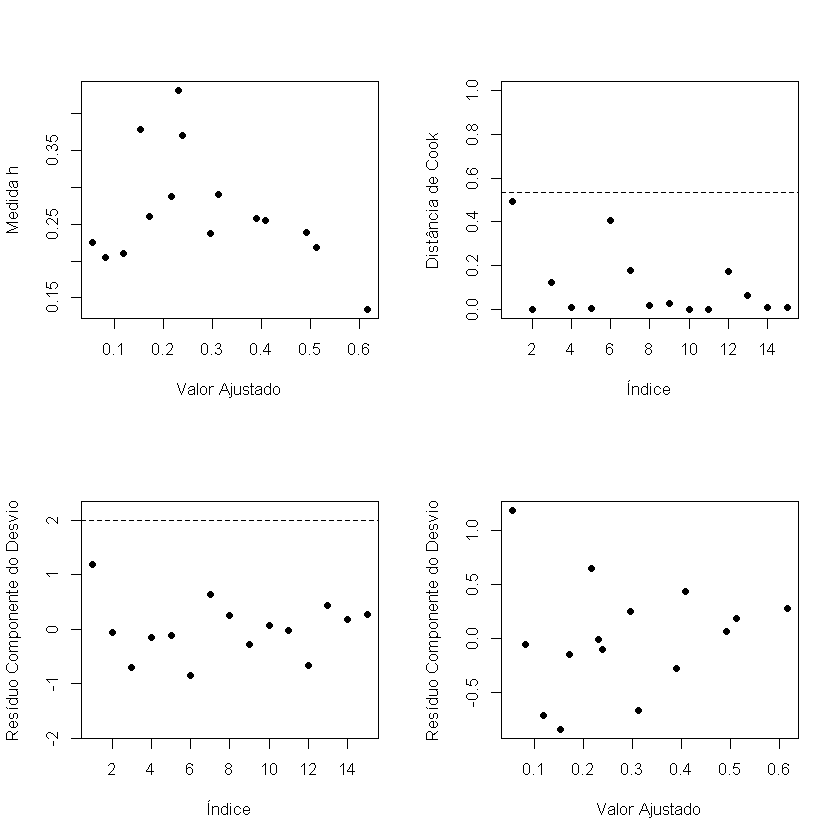

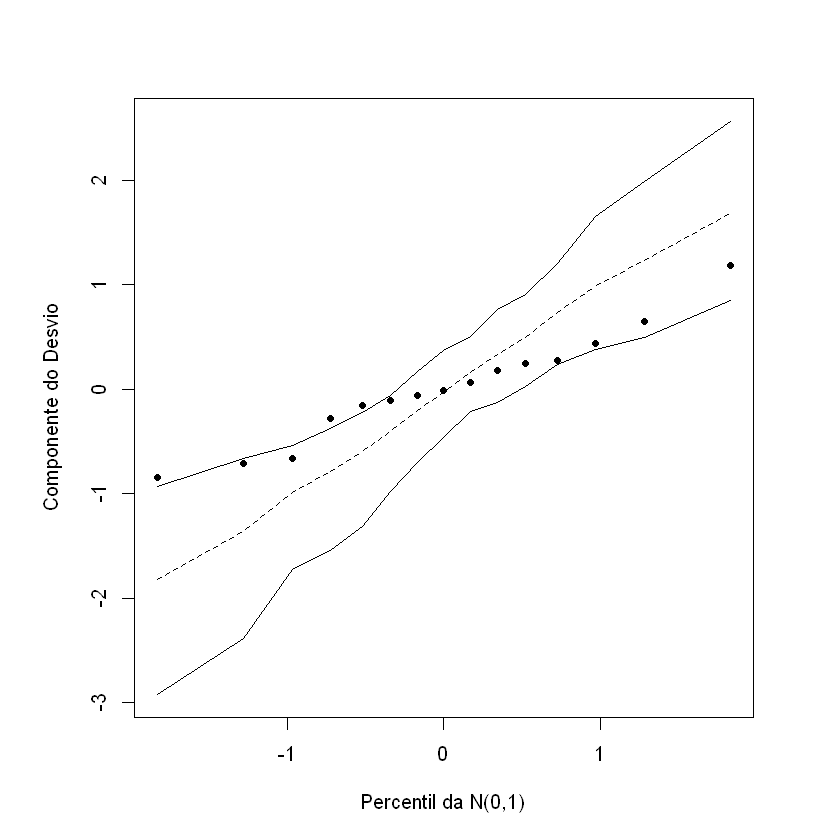

In [9]:
ntot=dados$n
source('C:/Users/moise/Desktop/regressao/capitulo 3/diag_bino.R')
source('C:/Users/moise/Desktop/regressao/capitulo 3/envelr_bino.R')

Podemos perceber uma tendência nos pontos no gráfico normal de probabilidade, os pontos estão "saindo" do envelope, mais uma vez indicando subdispersão. Notamos, também, que a variância tende a diminuir quanto maior o valor ajustado, indicando heterocedasticidade.

### Modelo Quase-Binomial

Buscando o estimador do parâmetro de dispersão através do ajuste "quasibinomial", e já corrigindo os erros padrões dos estimadores dos coeficientes $ \beta $

In [20]:
fit.model = glm(Xmat ~ tipo+tempo, family=quasibinomial)
phi = summary(glm(Xmat ~ tipo+tempo, family=quasibinomial))$dispersion
summary(fit.model)
phi


Call:
glm(formula = Xmat ~ tipo + tempo, family = quasibinomial)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.26555    0.20606 -15.848 6.38e-09 ***
tipo2        1.13255    0.16316   6.941 2.45e-05 ***
tipo3        1.63584    0.16790   9.743 9.59e-07 ***
tempo        0.42009    0.04845   8.670 3.02e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for quasibinomial family taken to be 0.2801727)

    Null deviance: 46.5612  on 14  degrees of freedom
Residual deviance:  2.9159  on 11  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 4


[1] 0.2801727

Corrigindo o resíduo componente do desvio para os gráficos de diagnóstico $ t^*_{D_i} = \sqrt{\hat{\phi}}t_{D_i} $

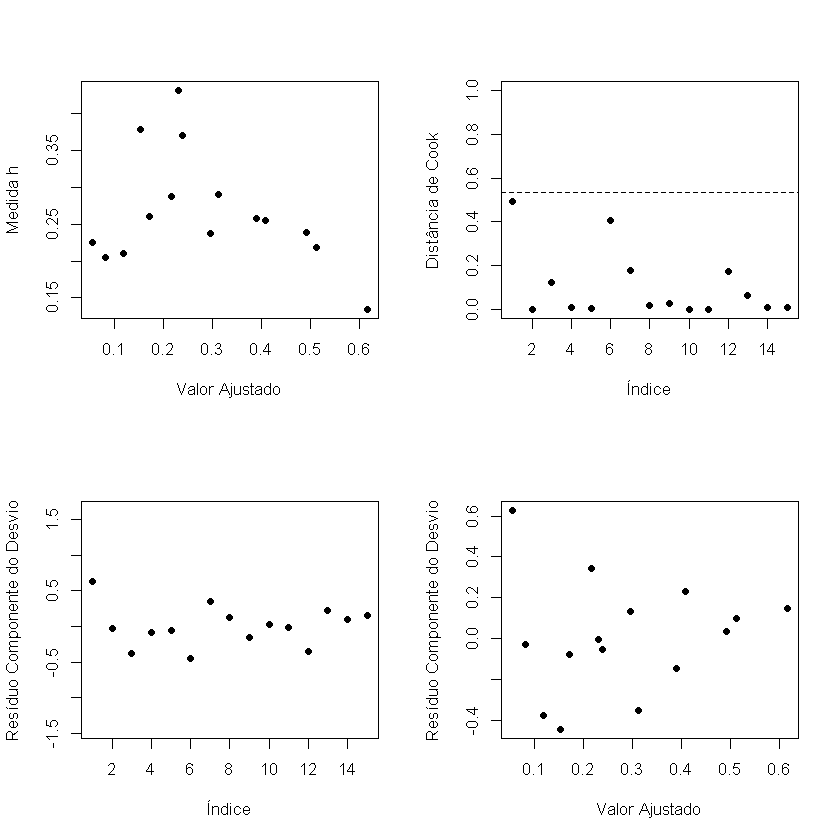

In [18]:
X <- model.matrix(fit.model)
n <- nrow(X)
p <- ncol(X)
w <- fit.model$weights
W <- diag(w)
H <- solve(t(X)%*%W%*%X)
H <- sqrt(W)%*%X%*%H%*%t(X)%*%sqrt(W)
h <- diag(H)
ts <- resid(fit.model,type="pearson")/sqrt(1-h)
td <- (sqrt(phi)*resid(fit.model,type="deviance")/sqrt(1-h))
di <- (h/(1-h))*(ts^2)
a <- max(td)
b <- min(td)
par(bg='white',mfrow=c(2,2))
plot(fitted(fit.model),h,xlab="Valor Ajustado", 
ylab="Medida h", pch=16)
#identify(fitted(fit.model), h, n=1)
#
plot(di,xlab="Índice", ylab="Distância de Cook",pch=16,ylim=c(0,1))
abline(2*p/n,0,lty=2)

#identify(di, n=1)
#
plot(td,xlab="Índice", ylab="Resíduo Componente do Desvio",
ylim=c(b-1,a+1), pch=16)
abline(2,0,lty=2)
abline(-2,0,lty=2)
#identify(td, n=1)
#
plot(fitted(fit.model), td,xlab="Valor Ajustado", 
ylab="Resíduo Componente do Desvio", pch=16)
#identify(fitted(fit.model), td, n=1)
par(mfrow=c(1,1))

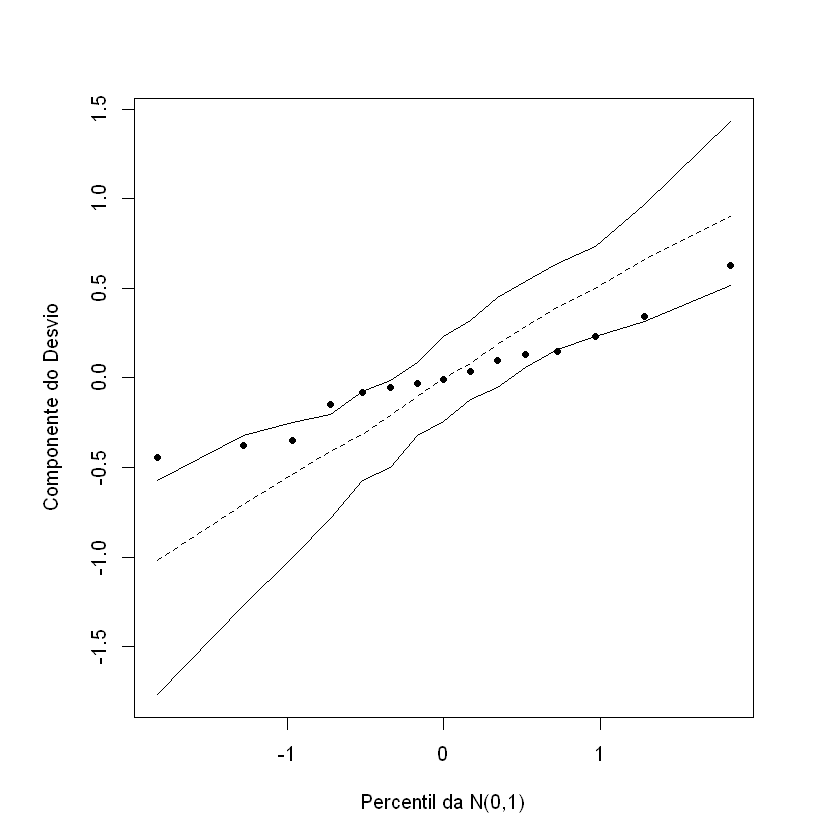

In [19]:
X <- model.matrix(fit.model)
k <- nrow(X)
e <- matrix(0,k,100)
tot <- numeric(k)
w <- fit.model$weights
W <- diag(w)
H <- solve(t(X)%*%W%*%X)
H <- sqrt(W)%*%X%*%H%*%t(X)%*%sqrt(W)
h <- diag(H)
td <- sort(sqrt(phi)*resid(fit.model, type="deviance")/sqrt(1-h))
#
for(i in 1:100){
  for(j in 1:k){
    dif <- runif(ntot[j]) - fitted(fit.model)[j]
    dif[dif>=0] <- 0
    dif[dif<0]  <- 1
    tot[j] <- sum(dif)}
  xmat <- cbind(tot,ntot-tot)
  fit <- glm(xmat ~ X, family=binomial)
  w <- fit$weights
  W <- diag(w)
  H <- solve(t(X)%*%W%*%X)
  H <- sqrt(W)%*%X%*%H%*%t(X)%*%sqrt(W)
  h <- diag(H)
  e[,i] <- sort(sqrt(phi)*resid(fit, type="deviance")/sqrt(1-h))}
#
e1 <- numeric(k)
e2 <- numeric(k)
#
for(i in 1:k){
  eo <- sort(e[i,])
  e1[i] <- (eo[2]+eo[3])/2
  e2[i] <- (eo[97]+eo[98])/2}
#
med <- apply(e,1,mean)
faixa <- range(td,e1,e2)
par(bg='white',pty="s")
# win.graph()
qqnorm(td,xlab="Percentil da N(0,1)",
       ylab="Componente do Desvio", ylim=faixa,pch=16, cex=0.8, main="")
#
par(new=TRUE)
qqnorm(e1,axes=F,xlab="",ylab="",type="l",ylim=faixa,lty=1, main="")
par(new=TRUE)
qqnorm(e2,axes=F,xlab="",ylab="", type="l",ylim=faixa,lty=1, main="")
par(new=TRUE)
qqnorm(med,axes=F,xlab="", ylab="", type="l", ylim=faixa, lty=2, main="")

